In [3]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from skimage.transform import resize
from pathlib import Path
from scipy.stats import hmean
import seaborn as sns
from dassl.data.datasets.base_dataset import Datum

In [10]:
with open("/data2/yhiro/data/eurosat/split_fewshot/shot_1-seed_1-9.pkl", "rb") as file:
    data = pickle.load(file)
data["train"][0].label

0

In [3]:
def extract_accuracy_from_log(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
        # 正規表現を使用してaccuracyを抽出
        match = re.search(r'accuracy: (\d+\.\d+)%', content)
        if match:
            return float(match.group(1))
    return None


In [10]:
datasets = [
    "caltech101", "dtd", "eurosat", "fgvc_aircraft", "food101", "imagenet", "oxford_flowers", "oxford_pets", "stanford_cars", "sun397", "ucf101"
]

#seeds = ["seed1", "seed2", "seed3", "seed4", "seed5"]
seeds = [f"seed1-{i}" for i in range(1, 101)]

#print(seeds)
all_data = {}
for dataset in datasets:
    energy_scores = []
    accuracies = []
    for seed in seeds:
        outdir_train = f"output/base2new/train_base/{dataset}/shots_1/DoCoCoOp/vit_b16_c4_ep10_batch1_ctxv1_zhou_etran_3/{seed}/"
        outdir_test = f"output/base2new/test_new/{dataset}/shots_1/DoCoCoOp/vit_b16_c4_ep10_batch1_ctxv1_zhou_etran_3/{seed}/"
        
        filedir = os.path.join(outdir_train, "etran_and_path.pkl")
        if os.path.exists(filedir):
            with open(filedir, "rb") as file:
                data = pickle.load(file)

            energy = data['energy']
            energy_logits = data['energy_logits'] * 10
            impath = data['impath']

            energy_mean = np.median(energy)
            accuracy_train = extract_accuracy_from_log(os.path.join(outdir_train, "log.txt"))
            accuracy_test = extract_accuracy_from_log(os.path.join(outdir_test, "log.txt"))
            
            if (accuracy_train is not None) and (accuracy_test is not None):
                energy_scores.append(energy_mean.tolist())
                accuracy = hmean([accuracy_train, accuracy_test])
                accuracies.append(accuracy)

                #print(f"dataset: {dataset}, energy: {energy_mean}, accuracy: {accuracy}")

                all_data[dataset] = {"energy": np.array(energy_scores), "accuracy": np.array(accuracies)}
                #print(len(energy_scores))

In [4]:
energy_logits

array([3.140625  , 3.15429688, 3.16601562, 3.1484375 , 3.14257812,
       3.15625   , 3.18359375, 3.15625   , 3.13867188, 3.1640625 ,
       3.16210938, 3.17578125, 3.18164062, 3.1875    , 3.1484375 ,
       3.18945312, 3.14648438, 3.14453125, 3.14453125])

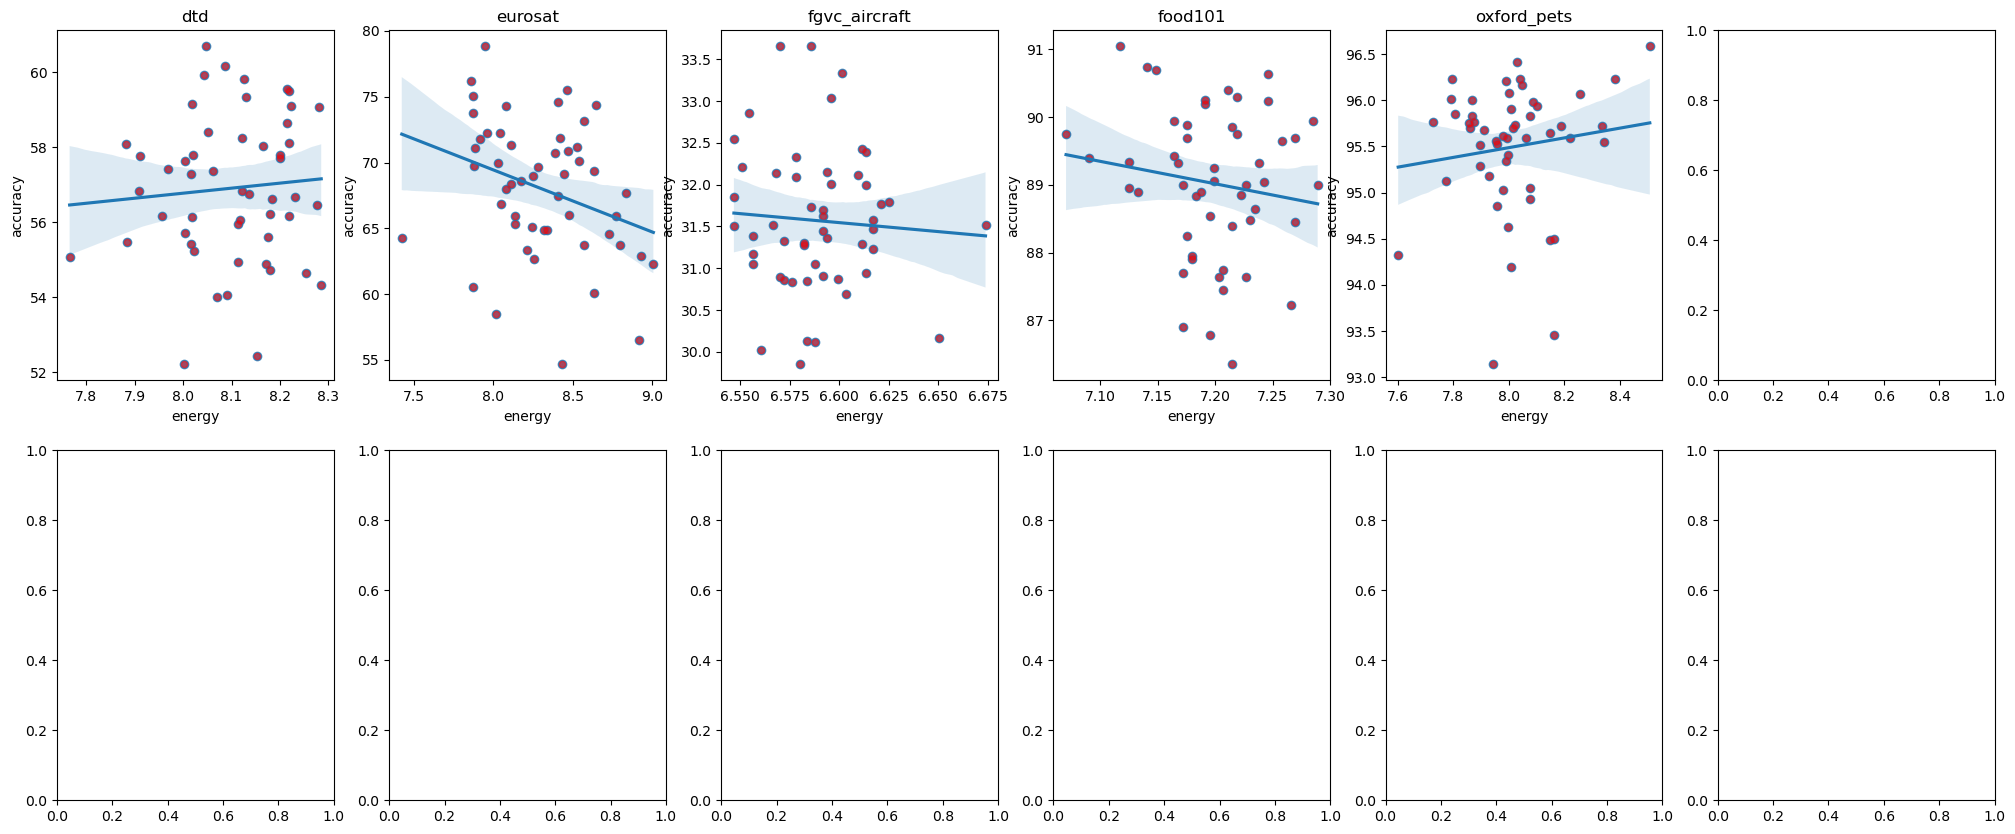

In [14]:
fig, ax = plt.subplots(2, 6, figsize=(25, 10))
ax = ax.ravel()

i = 0
for dataset, values in all_data.items():
    energy = values["energy"]
    accuracy = values["accuracy"]

    energy_sort_idx = np.argsort(energy)

    sns.regplot(x=energy, y=accuracy, ax=ax[i])

    ax[i].scatter(energy[energy_sort_idx], accuracy[energy_sort_idx], s=20, alpha=0.5, color="red")
    ax[i].set_title(dataset)
    ax[i].set_xlabel("energy")
    ax[i].set_ylabel("accuracy")

    i += 1

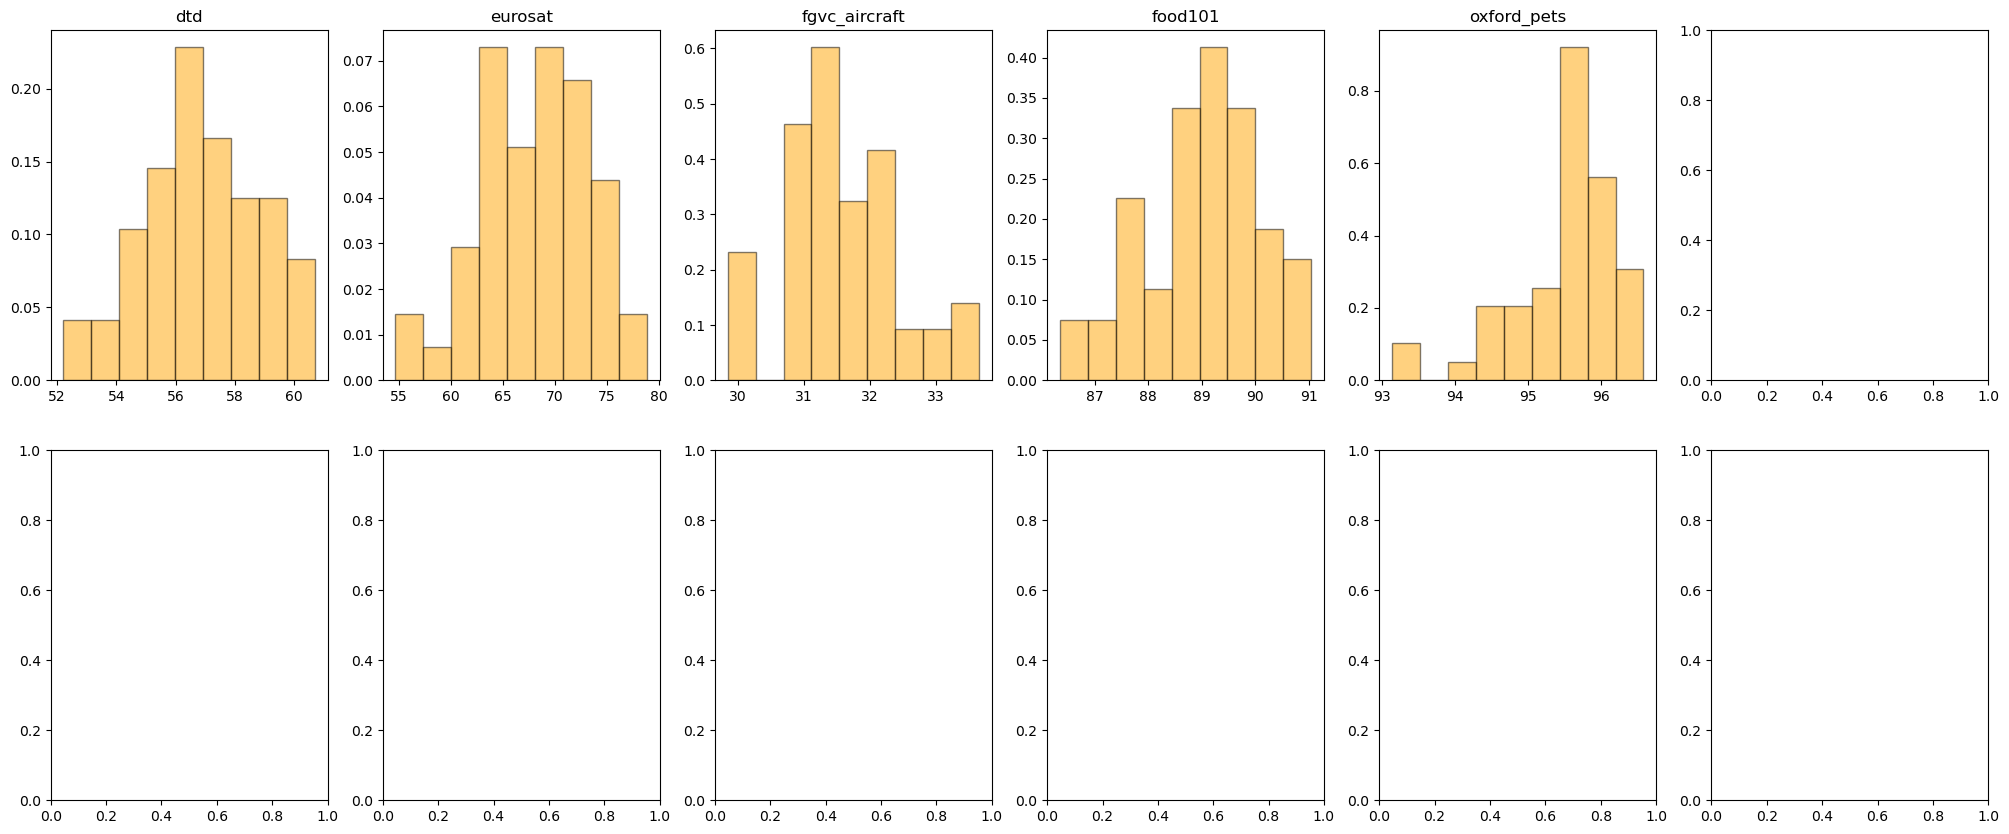

In [7]:
fig, ax = plt.subplots(2, 6, figsize=(25, 10))
ax = ax.ravel()

i = 0
for dataset, values in all_data.items():
    energy = values["energy"]
    accuracy = values["accuracy"]

    n_bin = 10
    x_max_1 = accuracy.max()
    x_min_1 = accuracy.min()
    bins_1 = np.linspace(x_min_1, x_max_1, n_bin)

    ax[i].hist(accuracy, bins=bins_1, alpha=0.5, density=True, ec='black', color="orange")
    ax[i].set_title(dataset)


    i += 1



52.20606060606061
52.41636536631779
53.99092592592593


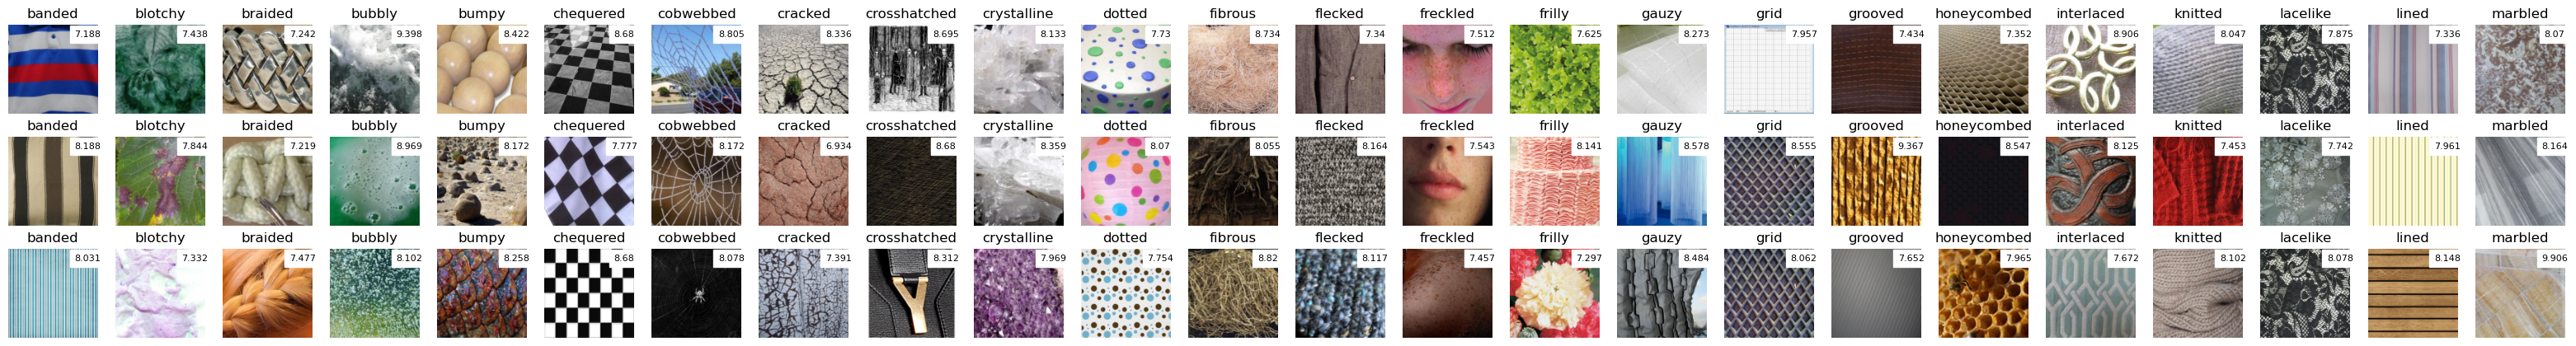

In [48]:
datasets = ["dtd"]
#seeds = ["seed1", "seed2", "seed3", "seed4", "seed5"]
seeds = [f"seed1-{i}" for i in range(1, 101)]

use_ranking = 3

fig, ax = plt.subplots(use_ranking, 24, figsize=(40, 5))
ax = ax.ravel()
target_size = (256, 256)
resize_size = (128, 128)

#print(seeds)
all_data = {}
for dataset in datasets:
    energy_scores = []
    energy_scores_all = []
    energy_stds = []
    accuracies = []
    impaths = []
    for seed in seeds:
        outdir_train = f"output/base2new/train_base/{dataset}/shots_1/DoCoCoOp/vit_b16_c4_ep10_batch1_ctxv1_zhou_etran_2/{seed}/"
        outdir_test = f"output/base2new/test_new/{dataset}/shots_1/DoCoCoOp/vit_b16_c4_ep10_batch1_ctxv1_zhou_etran_2/{seed}/"
        filedir = os.path.join(outdir_train, "etran_and_path.pkl")
        if os.path.exists(filedir):
            with open(filedir, "rb") as file:
                data = pickle.load(file)

            energy = data['energy']
            impath = data['impath']

            energy_mean = np.median(energy)
            energy_std = np.std(energy)
            accuracy_train = extract_accuracy_from_log(os.path.join(outdir_train, "log.txt"))
            accuracy_test = extract_accuracy_from_log(os.path.join(outdir_test, "log.txt"))
            
            if (accuracy_train is not None) and (accuracy_test is not None):
                energy_scores.append(energy_mean.tolist())
                accuracy = hmean([accuracy_train, accuracy_test])
                accuracies.append(accuracy)
                
                impaths.append(impath)
                energy_scores_all.append(energy)

                #print(f"dataset: {dataset}, energy: {energy_mean}, accuracy: {accuracy}")

                all_data[dataset] = {"energy": np.array(energy_scores), "accuracy": np.array(accuracies), 
                                     "energy_scores_all": np.array(energy_scores_all)}

    min_indecies = np.argsort(all_data[dataset]["accuracy"])[:3]
    
    i = 0
    for idx in min_indecies:
        impath = sorted(impaths[idx])
        print(all_data[dataset]["accuracy"][idx])
        segments = []
        for id, p in enumerate(impath):
            img = mpimg.imread(p)
            img_resized = resize(img, resize_size, anti_aliasing=True)
            if img_resized.ndim == 2:
                img_resized = np.stack((img_resized,) * 3, axis=-1)
            
            s = round(all_data[dataset]["energy_scores_all"][idx][id], 3)
            
            ax[i].imshow(img_resized)
            ax[i].set_title(p.split('/')[-2]) # label
            #ax[i].set_title(Path(p).name.split("_")[0])
            ax[i].text(0.89, 0.89, s, color='black', fontsize=8, ha='center', va='center', transform=ax[i].transAxes, backgroundcolor="white")
            ax[i].axis('off')
            i += 1

In [50]:
outdir_train = "output/base2new/train_base/ucf101/shots_1/DoCoCoOp/vit_b16_c4_ep10_batch1_ctxv1_zhou_etran_2/seed1-1/"
filedir = os.path.join(outdir_train, "etran_and_path.pkl")
if os.path.exists(filedir):
    with open(filedir, "rb") as file:
        data = pickle.load(file)
data

{'energy': array([7.359375  , 7.578125  , 7.31640625, 6.9296875 , 8.7578125 ,
        6.9609375 , 6.6171875 , 7.14453125, 8.796875  , 6.81640625,
        6.7890625 , 6.81640625, 7.73046875, 7.42578125, 6.71875   ,
        6.640625  , 7.22265625, 7.078125  , 7.2421875 , 7.06640625,
        8.328125  , 6.5234375 , 7.6484375 , 6.73828125, 9.453125  ,
        6.48046875, 6.62109375, 6.796875  , 7.3125    , 8.8828125 ,
        8.3671875 , 7.27734375, 8.75      , 6.79296875, 7.26953125,
        7.515625  , 7.4375    , 8.03125   , 7.40234375, 7.12109375,
        6.92578125, 7.2109375 , 7.34375   , 7.765625  , 9.015625  ,
        7.08203125, 9.8671875 , 7.63671875, 7.53515625, 8.234375  ,
        6.92578125]),
 'energy_logits': array([4.12890625, 4.14453125, 4.11328125, 4.12890625, 4.15625   ,
        4.1328125 , 4.125     , 4.1328125 , 4.13671875, 4.140625  ,
        4.09765625, 4.11328125, 4.12890625, 4.1484375 , 4.109375  ,
        4.109375  , 4.15234375, 4.1484375 , 4.13671875, 4.1015625 ,

In [25]:
all_data[dataset]["accuracy"][19]

58.4

In [ ]:
fig, ax = plt.subplots()

for dataset, values in all_data.items():
    energy = values["energy"]
    accuracy = values["accuracy"]

    energy_sort_idx = np.argsort(energy)

    ax.scatter(energy[energy_sort_idx], accuracy[energy_sort_idx], s=20, alpha=0.5, color="red")
    ax.set_title(dataset)
    ax.set_xlabel("energy")
    ax.set_ylabel("accuracy")
    #ax.set_ylim(88,98)